# Load and Initial Transforms - GL

## Setup

### Import Packages

In [ ]:
# Import packages
import pandas as pd
import numpy as np
from google.colab import drive
from collections import Counter
import matplotlib.pyplot as plt
from nltk.util import ngrams

pd.set_option("display.max_rows", None, # display all rows
              "display.max_columns", None, # display all columns
              "display.max_colwidth", None, # expand column width
              "display.html.use_mathjax", False) # disable Latex style mathjax rendering

In [ ]:
# !git status

fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


### Mount Drive and Navigate to NB locaiton

In [ ]:
drive.mount('/drive') 
%cd /drive/MyDrive/W266 Project/Colab Notebooks/Exploration
!pwd

Mounted at /drive
/drive/MyDrive/W266 Project/Colab Notebooks/Exploration
/drive/MyDrive/W266 Project/Colab Notebooks/Exploration


In [2]:
2+2

4

### Import Data
Data downloaded from [kaggle link](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview) to drive

In [ ]:
train_raw = pd.read_csv('../../data/jigsaw-toxic-comment-classification-challenge/train.csv').set_index('id')
test_raw = pd.read_csv('../../data/jigsaw-toxic-comment-classification-challenge/test.csv').set_index('id')
test_labels = pd.read_csv('../../data/jigsaw-toxic-comment-classification-challenge/test_labels.csv').set_index('id')

Test data and test labels are separate, so we will first combine that into a single df, much like train. We can choose to drop the labels later if necessary

In [ ]:
test_raw = test_raw.join(test_labels)

#### First, inspect the data

In [ ]:
print(f'There are {len(train_raw)} train observations, and {len(test_raw)} test observations.')

There are 159571 train observations, and 153164 test observations.


Taking a look at the datasets, we can see that there are six different types of 'toxic' comments, each of them labeled as 0 or 1 within the train set. If a value is 1, that means the comment was identified as a part of the column type. 

In [ ]:
train_raw.describe().loc[['min', 'max', 'count']]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
min,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0
count,159571.0,159571.0,159571.0,159571.0,159571.0,159571.0


The test data, however, does not take on only 0 or 1 values. it takes values of -1, 0, or 1. Values of -1 indicate a comment is not used for scoring, and the label type is lost. Therefore, we will remove any data where all column values are -1. 

In [ ]:
test_raw.describe().loc[['min', 'max', 'count']]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
max,1.0,1.0,1.0,1.0,1.0,1.0
count,153164.0,153164.0,153164.0,153164.0,153164.0,153164.0


Note: Wherever a value is -1, all other column values take on -1. Which is over half of 'test'

In [ ]:
test_labels.value_counts().head(1)

toxic  severe_toxic  obscene  threat  insult  identity_hate
-1     -1            -1       -1      -1      -1               89186
dtype: int64

Reducing test_raw down to usable values

In [ ]:
test_raw = test_raw[test_raw['toxic'] >= 0]

#### Now that test and train have the same form, we can inspect some of the data.

First, we can see that the data is incredibly unbalanced, with the majority of cases appearing with label of 0. 

In [ ]:
train_raw[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].value_counts()

toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0                143346
1      0             0        0       0       0                  5666
                     1        0       1       0                  3800
                                      0       0                  1758
                     0        0       1       0                  1215
       1             1        0       1       0                   989
       0             1        0       1       1                   618
0      0             1        0       0       0                   317
                     0        0       1       0                   301
1      1             1        0       1       1                   265
0      0             1        0       1       0                   181
1      1             1        0       0       0                   158
       0             0        0       0       1                   136
                              

This is partially misleading, though, as we don't expect all rows to be filled with 1's. This pseudo-one-hot-encoded structure is also not ideal for our models, so we will essentially pivot it to have one binary column, where we classify a comment as a threat (1) or non-threatening (0)

This is done with the label_violent function, and is generic enough to be used for test and train

## Transform to binary 'Violent' Variable

In [ ]:
def label_violent(df, violent_types):
    
    # Set the list of types to consider violent
    condition = ' == 1 | '.join(violent_types) + ' == 1'
    violent_inds = df.query(condition).index    # indices for violent = 1
    non_violent_inds = df.index.difference(violent_inds)    # indices for violent = 0

    # isolate violent and non-violent data
    violent = df.loc[violent_inds]
    violent['violent'] = 1
    non_violent = df.loc[non_violent_inds]
    non_violent['violent'] = 0

    # Stack violent and non-violent sub dfs
    df = pd.concat([violent, non_violent], axis = 0)
    
    # Return df with only comment text and violent = 1 or 0
    return df[['comment_text', 'violent']]


At this point we're assuming each of the below categories are 'threat' related, but we plan to check this assumption further. 

In [ ]:
violent_cats = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train = label_violent(train_raw, violent_cats)
test = label_violent(test_raw, violent_cats)

In [ ]:
train

,comment_text,violent
id,,
0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1
0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1
001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1
00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1
...,...,...
fffdc9a600fd8e06,==List of People banned from posting on this p...,0
fffe89233ffb33e1,How many times \nStyrofoam1994 how many times ...,0
ffff3a700c54e047,"""\n\nI am glad I can amuse you. Perhaps your t...",0


Now we can see there is a slightly lesser gap between 0 and 1

In [ ]:
train['violent'].value_counts()

0    143346
1     16225
Name: violent, dtype: int64

### Write Data to Folder

In [ ]:
train.to_csv('../../data/transformed/train.csv')
test.to_csv('../../data/transformed/test.csv')

### Load data back

## EDA

In [ ]:
train = pd.read_csv('../../data/transformed/train.csv').set_index('id')
test = pd.read_csv('../../data/transformed/test.csv').set_index('id')

In [ ]:
train.head()

,comment_text,violent
id,,
0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1
0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1
001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1
00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1


In [ ]:
def comment_transforms(comment_string):
    
    comment_string = str.lower(comment_string)
    comment_string = comment_string.replace('{','')\
                                    .replace('}','')\
                                    .replace('>','')\
                                    .replace('<','')\
                                    .replace('?','.')\
                                    .replace('-',' ')\
                                    .replace('...',' ')\
                                    .replace('\n',' ')\
                                    .replace(':','')\
                                    .replace('"','')\
                                    .replace('!','')\
    # More ideas
        # remove stopwords? 
        # remove all special characters? 
        # ?

    
    return comment_string



In [ ]:
def generate_vocab(comments, vocab_type = 'set'):
    comment_string = ''

    for comment in comments:
        comment_string += comment + ' '

    # Transforms, if any
    comment_string = comment_transforms(comment_string)

    tokens = str.split(comment_string)


    if vocab_type == 'set':
        comment_string = set(comment_string)        

    return tokens



Check the size of the corpus/vocab

In [ ]:
vocab = generate_vocab(train['comment_text'], 'full')
print(f'There are {len(vocab):,} tokens across the corpus, with {len(set(vocab)):,} unique tokens')

There are 10,703,166 tokens across the corpus, with 369,657 unique tokens


Next, let's transform each of the comments using the `comment_transforms` function above

In [ ]:
train.insert(1, 'comment_text_transf', train['comment_text'].apply(comment_transforms))

Studying a little more on the comment lengths

In [ ]:
# create a lambda function to measure comment length (after transform)
comment_len = (lambda x: len(str.split(x)))

lengths = train['comment_text_transf'].apply(comment_len)

The average comment is 67 tokens long with a max of 1,411 and 75th percentile length of 75



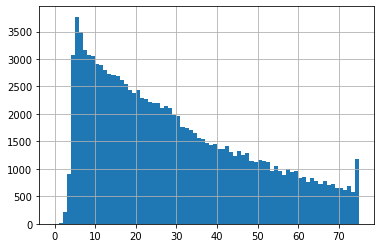

In [ ]:
print(f'The average comment is {round(lengths.describe()[1]):,} \
tokens long with a max of {round(lengths.describe()[7]):,} \
and 75th percentile length of {round(lengths.describe()[6]):,}\n')

lengths.hist(bins = 75, range = (0,75))

Checking if there is an obvious difference in lengths between violent and non-violent comments. Both of the comments seem to have most of their density between 0 and 75, but non-violent comments seem to be slightly longer on average. 

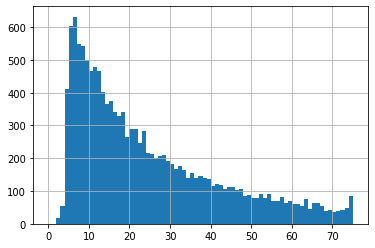

In [ ]:
lengths_v = train[train['violent'] == 1]['comment_text_transf'].apply(comment_len)
lengths_nv = train[train['violent'] == 0]['comment_text_transf'].apply(comment_len)
lengths_v.hist(bins = 75, range = (0,75))

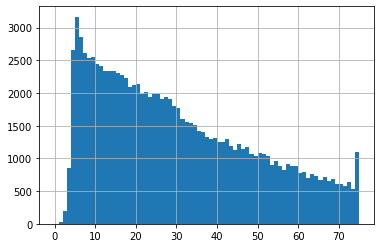

In [ ]:
lengths_nv.hist(bins = 75, range = (0,75))

In [ ]:
# GL AR: count and plot most common words for each type
# Count and plot most common stop-words
# Explore common n-grams 
# great resource here: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

Next, we can explore some word frequencies. We start by counting the occurrences of each word in the vocab, and then doing a few pieces of EDA. 

In [ ]:
def count_frequency(token_list):
    # Use Counter to create a dictionary of tokens and their frequencies
    count_dict = Counter(token_list)

    # Sort the vocab counts in descending order - returning a list
    sorted_vocab_count = sorted(count_dict.items(), key = lambda x: x[1], reverse = True)

    # Pull the tokens and counts for plotting
    token_list = [x[0] for x in sorted_vocab_count]
    counts_list = [x[1] for x in sorted_vocab_count]

    return (sorted_vocab_count, token_list, counts_list)



In [ ]:
lis, token_list, counts_list = count_frequency(vocab)

In [ ]:
def plot_count_bars(items, counts, top_n = 10, orientation = 'h'):
    
    # Set up a plot
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    
    # plot horizontal
    if orientation == 'h':
        ax.barh(items[:top_n], counts[:top_n])
        ax.invert_yaxis()
    elif orientation == 'v':
        ax.bar(items[:top_n], counts[:top_n])
    else: 
        print('ERROR: please choose a valid orientation parameter')

    plt.show()

Across the entire vocabulary, we can see that the most common words are mostly stop words. 

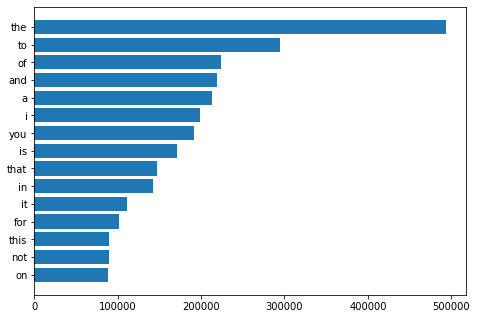

In [ ]:
plot_count_bars(token_list, counts_list, 15)

Before totally removing stop-words, let's see if there are any noticable differeces between frequency of unigrams in violent vs. non-violent commments. 

We can see here that the number of unique tokens across violent comments is 1/7th the size of regular comment corpus. That *may* be helpful later in identifying unique terms that are commonly used in violent text

In [ ]:
# Generate violent vocab
v_vocab = generate_vocab(train[train['violent'] == 1]['comment_text_transf'], 'full')
print(f'There are {len(v_vocab):,} tokens across the violent corpus, with {len(set(v_vocab)):,} unique tokens')

# Generate violent vocab
nv_vocab = generate_vocab(train[train['violent'] == 0]['comment_text_transf'], 'full')
print(f'There are {len(nv_vocab):,} tokens across the non-violent corpus, with {len(set(nv_vocab)):,} unique tokens')

There are 857,091 tokens across the violent corpus, with 54,850 unique tokens
There are 9,846,104 tokens across the non-violent corpus, with 352,622 unique tokens


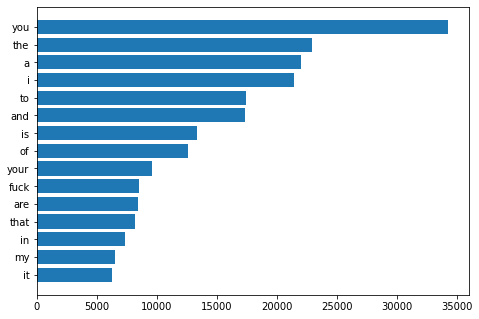

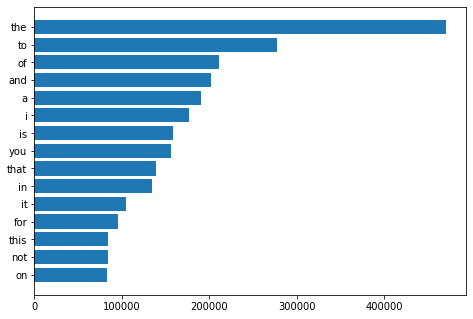

In [ ]:
# GET FREQUENCY COUNTS FOR BOTH VOCABS
# Frequency of Violent tokens
v_lis, v_tokens, v_counts = count_frequency(v_vocab)

# Frequency of non-Violent tokens
nv_lis, nv_tokens, nv_counts = count_frequency(nv_vocab)

# PLOT FREQUENCY COUNTS FOR EACH VOCAB
plot_count_bars(v_tokens, v_counts, 15)
plot_count_bars(nv_tokens, nv_counts, 15)

In [ ]:
n_tokens = 50
print(f'of the top {n_tokens} tokens, {len(set(v_tokens[:n_tokens]).intersection(set(nv_tokens[:n_tokens])))} are shared between the non-violent and violent vocabularies')

of the top 50 tokens, 35 are shared between the non-violent and violent vocabularies


In [ ]:
print(f'Violent comments have the following set of tokens outside of the non-violent {n_tokens} most frequent: \n {set(v_tokens[:n_tokens]).difference(set(nv_tokens[:n_tokens]))}')

Violent comments have the following set of tokens outside of the non-violent 50 most frequent: 
 {'get', 'am', "don't", 'fuck', 'shit', 'u', 'go', 'hate', 'nigger', 'me', 'suck', 'like', 'wikipedia', 'fucking', 'who'}


Some of the above tokens seem like they may be heavier correllated with violent comments, whereas others are just stop-words that shouldn't hold too much weight. 

How would this look if we were checking out bi- or tri-grams instead of uni-grams? I would expect to see a little bit more differentiation between violent and non-violent comments

In [ ]:
def create_ngrams(vocab, n):
    return list(ngrams(vocab, n))

In [ ]:
# Create bi-, tri-, and 5-grams fro the non-violent and violent comments
v_2grams = create_ngrams(v_vocab, 2)
v_3grams = create_ngrams(v_vocab, 3)
v_5grams = create_ngrams(v_vocab, 5)

nv_2grams = create_ngrams(nv_vocab, 2)
nv_3grams = create_ngrams(nv_vocab, 3)
nv_5grams = create_ngrams(nv_vocab, 5)


In [ ]:
v_2_lis, v_2_tokens, v_2_counts = count_frequency(v_2grams)
v_3_lis, v_3_tokens, v_3_counts = count_frequency(v_3grams)
v_5_lis, v_5_tokens, v_5_counts = count_frequency(v_5grams)

nv_2_lis, nv_2_tokens, nv_2_counts = count_frequency(nv_2grams)
nv_3_lis, nv_3_tokens, nv_3_counts = count_frequency(nv_3grams)
nv_5_lis, nv_5_tokens, nv_5_counts = count_frequency(nv_5grams)

In [ ]:
# Convert token arrays into strings for plotting
v_2_tokens = [str(x) for x in v_2_tokens]
v_3_tokens = [str(x) for x in v_3_tokens]
v_5_tokens = [str(x) for x in v_5_tokens]

nv_2_tokens = [str(x) for x in nv_2_tokens]
nv_3_tokens = [str(x) for x in nv_3_tokens]
nv_5_tokens = [str(x) for x in nv_5_tokens]

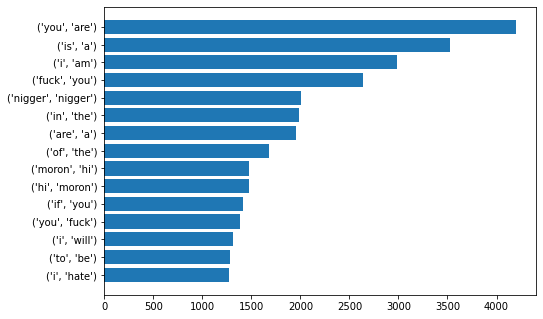

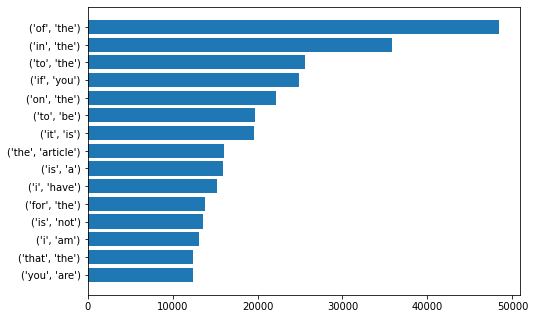

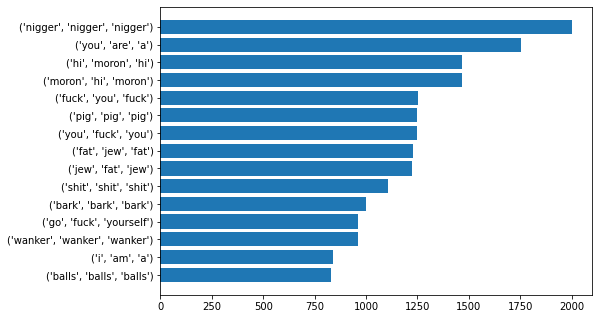

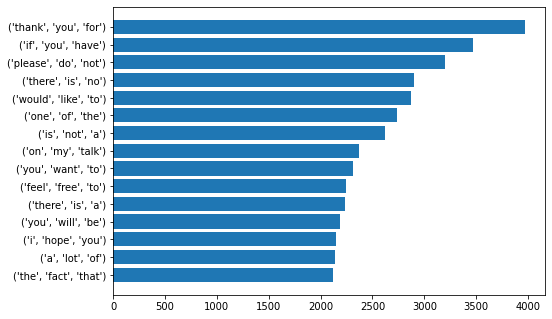

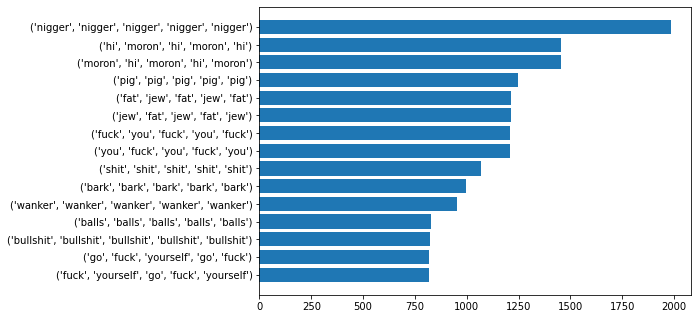

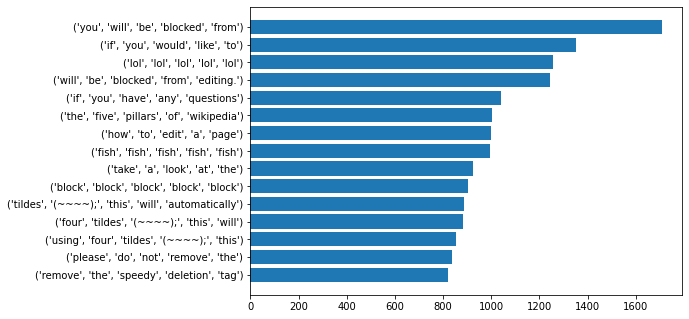

In [ ]:
plot_count_bars(v_2_tokens, v_2_counts, 15)
plot_count_bars(nv_2_tokens, nv_2_counts, 15)

plot_count_bars(v_3_tokens, v_3_counts, 15)
plot_count_bars(nv_3_tokens, nv_3_counts, 15)

plot_count_bars(v_5_tokens, v_5_counts, 15)
plot_count_bars(nv_5_tokens, nv_5_counts, 15)

In [ ]:
v_3_tst = [str(x) for x in v_3_tokens]
v_3_tst

["('nigger', 'nigger', 'nigger')",
 "('you', 'are', 'a')",
 "('hi', 'moron', 'hi')",
 "('moron', 'hi', 'moron')",
 "('fuck', 'you', 'fuck')",
 "('pig', 'pig', 'pig')",
 "('you', 'fuck', 'you')",
 "('fat', 'jew', 'fat')",
 "('jew', 'fat', 'jew')",
 "('shit', 'shit', 'shit')",
 "('bark', 'bark', 'bark')",
 "('go', 'fuck', 'yourself')",
 "('wanker', 'wanker', 'wanker')",
 "('i', 'am', 'a')",
 "('balls', 'balls', 'balls')",
 "('bullshit', 'bullshit', 'bullshit')",
 "('fuck', 'yourself', 'go')",
 "('yourself', 'go', 'fuck')",
 "('nipple', 'nipple', 'nipple')",
 "('faggot', 'faggot', 'faggot')",
 "('you', 'suck', 'you')",
 "('suck', 'you', 'suck')",
 "('ass.', 'i', 'ass.')",
 "('i', 'ass.', 'i')",
 "('die', 'fag', 'die')",
 "('fag', 'die', 'fag')",
 "('faggots', 'faggots', 'faggots')",
 "('fucksex', 'fucksex', 'fucksex')",
 "('fuck', 'yourselfgo', 'fuck')",
 "('your', 'a', 'dickhead')",
 "('a', 'dickhead', 'your')",
 "('dickhead', 'your', 'a')",
 "('yourselfgo', 'fuck', 'yourselfgo')",
 "('i

In [ ]:
# Transformations have been applied to our train, so now we save it off for modeling
model_train = train[['comment_text_transf', 'violent']]

# Applying the transformations to test to also save off
test.insert(1, 'comment_text_transf', test['comment_text'].apply(comment_transforms))
model_test = test[['comment_text_transf', 'violent']]

In [ ]:
np.array(model_test.head())

array([['== arabs are committing genocide in iraq, but no protests in europe. ==    may europe also burn in hell.',
        1],
       ['dj robinson is gay as hell he sucks his dick so much', 1],
       ['fuck off, you anti semitic cunt.  |', 1],
       ["how dare you vandalize that page about the hms beagle don't vandalize again, demon",
        1],
       ['no, he is an arrogant, self serving, immature idiot. get it right.',
        1]], dtype=object)

In [ ]:
model_train.to_csv('../../data/transformed/final/train.csv', index=False)
model_test.to_csv('../../data/transformed/final/test.csv', index=False)